# Reversal learning task

In this notebook I am going to analyze the data from the reversal experiment.

This notebook is dedicated to the model free analysis.



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import pymc3 as pm
import arviz as az

from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

### get data and age

In [2]:
#Load Age and MoCA scores from the session log file.
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

# Change name of the first column to 'sub'
age.columns.values[0] = moca.columns.values[0] = "sub"

# remove unnecessary rows
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

print("Number of participants with age: ",age.shape[0],'; females: ', age[age['gender']=='F'].shape[0])
# merge files
age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_'))) # remove the AG_ prfix from the subject number
age['sub'] = age['sub'].astype(int)
age['age'] = age.age.astype('int')

print('Number of participants with MoCA: ', age.shape[0], '; MoCA > 25:', age[age.moca_score>25].shape[0],'; females: ', age[age['gender']=='F'].shape[0])
print('mean:', np.mean(age.age), 'std:', np.std(age.age), 'min-max:',np.min(age.age),np.max(age.age))
age_c = age[age['moca_score']>25]
print('mean:', np.mean(age_c.age), 'std:', np.std(age_c.age), 'min-max:',np.min(age_c.age),np.max(age_c.age))

Number of participants with age:  95 ; females:  45
Number of participants with MoCA:  85 ; MoCA > 25: 67 ; females:  40
mean: 53.71764705882353 std: 22.21743447078595 min-max: 18 89
mean: 51.1044776119403 std: 22.126592583449817 min-max: 18 88


In [3]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'
db = pd.DataFrame()

for sub in glob(glober):
    temp = pd.read_csv(sub)
    temp['sub']= sub.split("_")[2]
    temp['CSp'] = temp.rectOri[2]
    db = db.append(temp)

print("number of participants with reversal data: ", len(np.unique(db['sub'])))

number of participants with reversal data:  92


In [4]:
db['sub'] = db['sub'].astype('int')
db = db.merge(age, left_on='sub', right_on='sub')
db = db[db.moca_score >25]
print('Valid subjects (MoCA>25): ', len(np.unique(db['sub'])))

Valid subjects (MoCA>25):  67


In [5]:
x = db[db['RT']==-1].groupby('sub').count()['rating']
x = x[x>5].reset_index()
print(x)
db = db[~db['sub'].isin(x['sub'].values)]


   sub  rating
0  102      13


trials with no response get rating of 0. 

here we replace it with NaN as 0 looks like a very low rating

plot without 0s

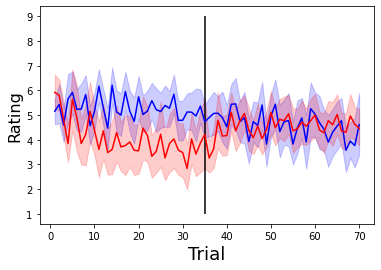

In [6]:
db['rating_clean'] = db.rating
db['rating_clean'] = db.rating_clean.replace(0, np.nan)
fig1 = db[db.rating!=0]

sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri==fig1.CSp)], color='blue')
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri!=fig1.CSp)], color='red')
plt.xlabel('Trial', fontsize=18)
plt.ylabel('Rating', fontsize=16)
plt.vlines(x=35, ymin=1, ymax=9, colors='black')

overall disterbution of responses

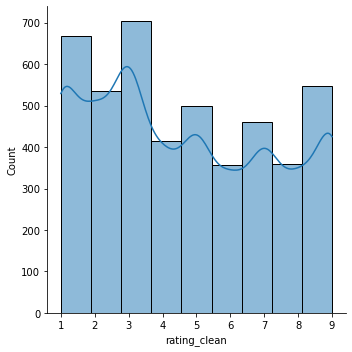

In [7]:
sns.displot(db.rating_clean, kde=True, bins=9)

## Model free analysis

1. Acquisition strength (ACQ) = the difference between the mean ratings of CS+ and CS− in the second half of the acquisition stage (late acquisition)

2. change in rating of CS+ (ΔCS+) between late acquisition and late reversal

3. change in rating of CS- (ΔCS-) between late reversal and late acquisition


In [8]:
subs = db['sub'].unique()

model_free = pd.DataFrame()

for sub in subs:
    df = db[db['sub'] == sub]
    df = df[df.rectValue == 0].reset_index()
    trials = []
    for i in range(len(df)):
    
        temp = df[:i+1]
        trials.append(len(temp[temp['rectOri']== temp['rectOri'][i]]))

    df['trials'] = trials
    
    
    CSaA = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    CSbA = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    
    CSaeR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])
    CSbeR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])

    CSaR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] > 21)]['rating_clean'])
    CSbR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] > 21)]['rating_clean'])

    ACQ = CSaA - CSbA
    dCSa = CSaA - CSaR 
    dCSb = CSbR - CSbA
    
    temp = pd.DataFrame({'sub':[sub], 'ACQ':[ACQ], 'ΔCSa':[dCSa], 'ΔCSb':[dCSb], 
                         'age':[df.age[0]], 'CSaeR': [CSaeR], 'CSaR':[CSaR], 
                        'CSbeR':[CSbeR], 'CSbR':[CSbR]})
    model_free = model_free.append(temp)
    
model_free = model_free.dropna()
print('Model free subjects: ', model_free.shape[0])

Model free subjects:  66


## T-test for a single sample

Compare if participants were able to learn and update values.

In [9]:
with pm.Model() as ACQ:
    
    ACQ = pm.Normal('ACQ', 0, 5)
    CSa = pm.Normal('CSa', 0, 5)
    CSb = pm.Normal('CSb', 0, 5)
    eps1 = pm.Exponential('eps1', 5)
    eps2 = pm.Exponential('eps2', 5)
    eps3 = pm.Exponential('eps3', 5)
    #nu = pm.InverseGamma("nu", alpha=1, beta=1)

    
    likelihood1 = pm.Normal("likelihood1", mu=ACQ, sigma=eps1, observed=model_free.ACQ)
    likelihood2 = pm.Normal("likelihood2", mu=CSa, sigma=eps2, observed=model_free.ΔCSa)
    likelihood3 = pm.Normal("likelihood3", mu=CSb, sigma=eps3, observed=model_free.ΔCSb)
    
    ttest_trace = pm.sample(tune=2000, return_inferencedata=True, target_accept=0.9)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps3, eps2, eps1, CSb, CSa, ACQ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


Text(1.5, 8, 'µ = 1.05,\n89% HDPi = 0.69-1.38')

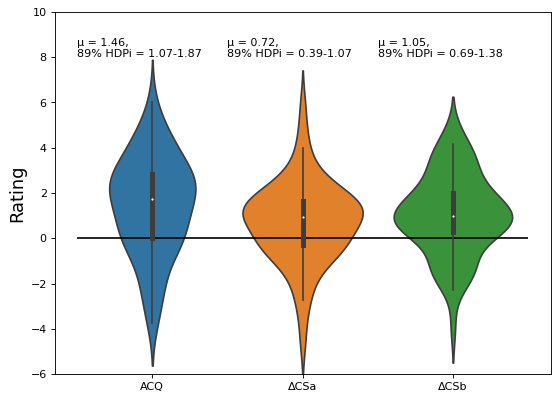

In [10]:
ttest = az.summary(ttest_trace, var_names=['ACQ','CSa','CSb'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

fig2 = pd.melt(model_free, id_vars='sub', value_vars=['ACQ', 'ΔCSa', 'ΔCSb'], value_name='score', var_name = 'test')
plt.figure(figsize=(8,6), dpi=80)
sns.violinplot(x = 'test', y='score', data=fig2)
plt.xlabel('')
plt.ylim(-6,10)
plt.ylabel('Rating', fontsize=16)
plt.hlines(y=0,xmin=-0.5,xmax=2.5, color='black')

text = 'µ = {:.2f},\n89% HDPi = {:.2f}-{:.2f}'.format(float(ttest['mean']['ACQ']),
                                                        float(ttest['hdi_5.5%']['ACQ']),
                                                        float(ttest['hdi_94.5%']['ACQ']))
plt.text(-0.5, 8.5, text, fontsize=10)

text = 'µ = {:.2f},\n89% HDPi = {:.2f}-{:.2f}'.format(float(ttest['mean']['CSa']),
                                                        float(ttest['hdi_5.5%']['CSa']),
                                                        float(ttest['hdi_94.5%']['CSa']))

plt.text(0.5, 8.5, text, fontsize=10)

text = 'µ = {:.2f},\n89% HDPi = {:.2f}-{:.2f}'.format(float(ttest['mean']['CSb']),
                                                        float(ttest['hdi_5.5%']['CSb']),
                                                        float(ttest['hdi_94.5%']['CSb']))
plt.text(1.5, 8.5, text, fontsize=10)


## Correlation between age and learning

In [11]:
def corr(df):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*df.x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        #likelihood = pm.Normal("likelihood", mu=y_hat, sigma=eps, observed=y)

        likelihood = pm.StudentT(
            "likelihood", mu=y_hat, sigma=eps, nu=nu, observed=df.y
        )

        trace_robust = pm.sample(tune=3000, draws=1000, return_inferencedata=True, target_accept=0.95)
        
    return(trace_robust)

In [12]:
acq_corr = corr(pd.DataFrame({'x': model_free.age/100, 'y': model_free.ACQ}).reset_index(drop=True))
csa_corr = corr(pd.DataFrame({'x': model_free.age/100, 'y': model_free.ΔCSa}).reset_index(drop=True))
csb_corr = corr(pd.DataFrame({'x': model_free.age/100, 'y': model_free.ΔCSb}).reset_index(drop=True))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.


In [13]:
cortestAC = az.summary(acq_corr, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
cortestDA = az.summary(csa_corr, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
cortestDB = az.summary(csb_corr, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

,mean,hdi_5.5%,hdi_94.5%
slope,-0.526,-1.695,0.583
intercept,1.717,1.089,2.432


Text(20, -4, 'β = -0.56,\n89% HDPi = -1.49 - 0.48')

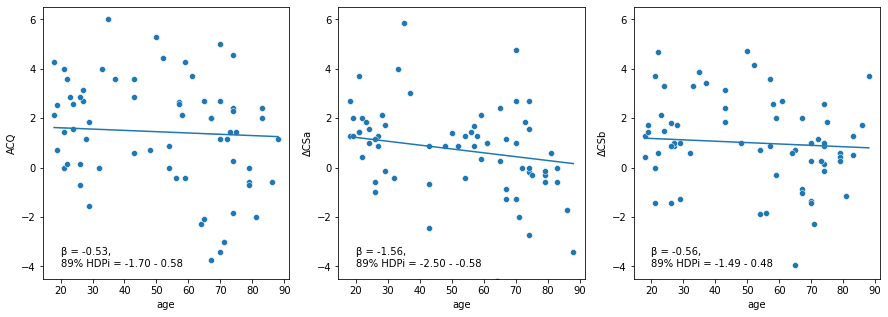

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(y = 'ACQ',  x = 'age', data=model_free, ax=axes[0])
sns.scatterplot(y = 'ΔCSa', x = 'age', data=model_free, ax=axes[1])
sns.scatterplot(y = 'ΔCSb', x = 'age', data=model_free, ax=axes[2])

sns.lineplot(model_free.age,cortestAC['mean']['intercept']+cortestAC['mean']['slope']*model_free.age/100, ax=axes[0])
sns.lineplot(model_free.age,cortestDA['mean']['intercept']+cortestDA['mean']['slope']*model_free.age/100, ax=axes[1])
sns.lineplot(model_free.age,cortestDB['mean']['intercept']+cortestDB['mean']['slope']*model_free.age/100, ax=axes[2])

axes[0].set(ylim=(-4.5,6.5))
axes[1].set(ylim=(-4.5,6.5))
axes[2].set(ylim=(-4.5,6.5))


text = 'β = {:.2f},\n89% HDPi = {:.2f} - {:.2f}'.format(float(cortestAC['mean']['slope']),
                                                        float(cortestAC['hdi_5.5%']['slope']),
                                                        float(cortestAC['hdi_94.5%']['slope']))
axes[0].text(20, -4, text, fontsize=10)

text = 'β = {:.2f},\n89% HDPi = {:.2f} - {:.2f}'.format(float(cortestDA['mean']['slope']),
                                                        float(cortestDA['hdi_5.5%']['slope']),
                                                        float(cortestDA['hdi_94.5%']['slope']))
axes[1].text(20, -4, text, fontsize=10)

text = 'β = {:.2f},\n89% HDPi = {:.2f} - {:.2f}'.format(float(cortestDB['mean']['slope']),
                                                        float(cortestDB['hdi_5.5%']['slope']),
                                                        float(cortestDB['hdi_94.5%']['slope']))
axes[2].text(20, -4, text, fontsize=10)


In [16]:
model_free.to_csv('data/model_free.csv')